In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
import seaborn as sns

In [3]:
tourist_data = pd.read_csv('final_final_tourist_data.csv')

In [4]:
#Vectorizing Tags column using TF-IDF

tags_vectorizer = TfidfVectorizer(stop_words='english')
tags_tfidf_matrix = tags_vectorizer.fit_transform(tourist_data['Tags'].fillna(''))

In [1]:
# print(tags_tfidf_matrix)

In [6]:
# Reducing dimensionality of the TF-IDF matrix using Truncated SVD

svd = TruncatedSVD(n_components=100, random_state=42)
tags_tfidf_reduced = svd.fit_transform(tags_tfidf_matrix)

In [2]:
# print(tags_tfidf_reduced)

In [8]:
# Using gaussian Distribution for the simulation of user ratings to make it more realistic
np.random.seed(42)  
num_users = 200  

user_ratings = []

for attraction_id in range(len(tourist_data)):
    num_ratings = np.random.randint(1, 10)  
    for _ in range(num_ratings):
        user_id = np.random.randint(1, num_users + 1)
        rating = np.clip(np.random.normal(loc=3.5, scale=1.0), 0, 5)
        user_ratings.append({
            'User_ID': user_id,
            'Attraction': tourist_data['Name'][attraction_id],
            'User_Rating': rating
        })

In [9]:
user_ratings_df = pd.DataFrame(user_ratings)
user_ratings_df.to_csv('tourist_data_with_ratings.csv', index=False)

In [10]:
# Scale the Rating, Latitude, and Longitude columns to bring them to the same range

scaler = MinMaxScaler()
tourist_data[['Rating', 'Latitude', 'Longitude']] = scaler.fit_transform(tourist_data[['Rating', 'Latitude', 'Longitude']])

In [11]:
# MErging the user ratings with the original data 
user_ratings_merged = user_ratings_df.merge(tourist_data, left_on='Attraction', right_on='Name')

In [12]:
# Features from textual and numerical attributes are combined
tags_features = svd.transform(tags_vectorizer.transform(user_ratings_merged['Tags'].fillna('')))
other_features = user_ratings_merged[['Rating', 'Latitude', 'Longitude']].values
combined_features = np.hstack([tags_features, other_features])

In [13]:
X = combined_features
y = user_ratings_merged['User_Rating'].values

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Train a KNeighborsRegressor to predict user ratings
knn_model = KNeighborsRegressor(n_neighbors=5, metric='cosine')
knn_model.fit(X_train, y_train)

KNeighborsRegressor(metric='cosine')

In [16]:
y_knn_pred = []
batch_size = 1000
for i in range(0, X_test.shape[0], batch_size):
    X_test_batch = X_test[i:i + batch_size]
    y_knn_pred_batch = knn_model.predict(X_test_batch)
    y_knn_pred.extend(y_knn_pred_batch)

In [17]:
y_knn_pred = np.array(y_knn_pred)

In [18]:
rmse_knn = np.sqrt(mean_squared_error(y_test, y_knn_pred))
mae_knn = mean_absolute_error(y_test, y_knn_pred)
r2_knn = r2_score(y_test, y_knn_pred)

print(f"KNN Regressor - RMSE: {rmse_knn:.4f}")
print(f"KNN Regressor - MAE: {mae_knn:.4f}")
print(f"KNN Regressor - R^2 Score: {r2_knn:.4f}")


KNN Regressor - RMSE: 1.0303
KNN Regressor - MAE: 0.8377
KNN Regressor - R^2 Score: -0.1854


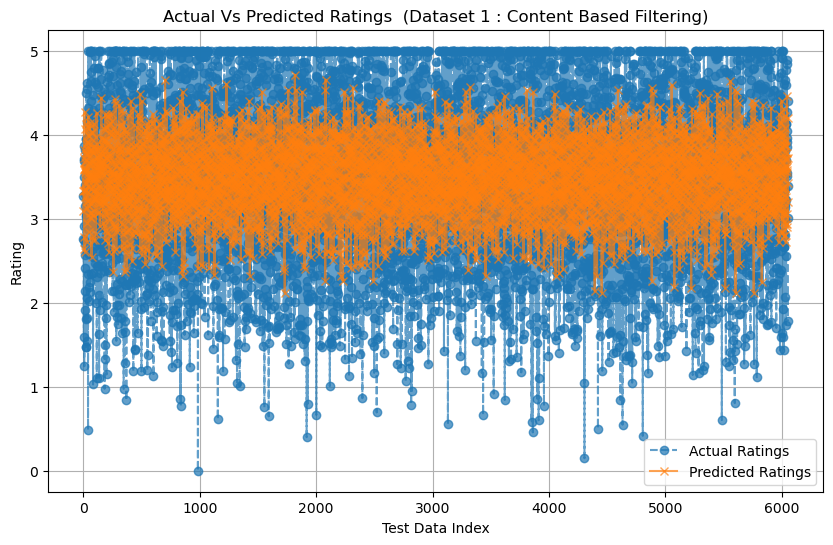

In [19]:
plt.figure(figsize=(10, 6))
x_values = range(len(y_test))
plt.plot(x_values, y_test, label='Actual Ratings', alpha=0.7, marker='o', linestyle='--')
plt.plot(x_values, y_knn_pred, label='Predicted Ratings', alpha=0.7, marker='x', linestyle='-')
plt.xlabel('Test Data Index')
plt.ylabel('Rating')
plt.title('Actual Vs Predicted Ratings  (Dataset 1 : Content Based Filtering)')
plt.legend()
plt.grid(True)
plt.show()

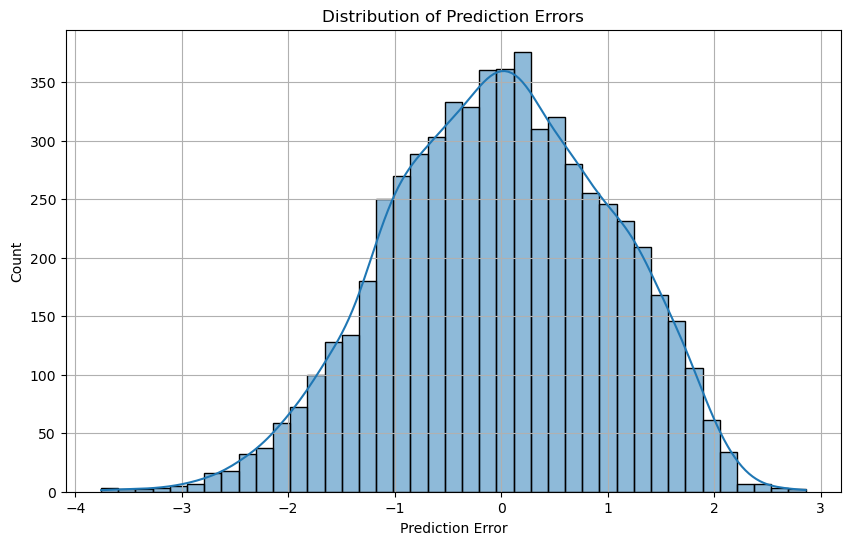

In [20]:
plt.figure(figsize=(10, 6))
errors = y_test - y_knn_pred
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

In [21]:
print("User Ratings for Each Attraction:")
print(user_ratings_df.head(20))

User Ratings for Each Attraction:
    User_ID                          Attraction  User_Rating
0       180                Hungry Boba Pizzeria     2.388120
1        75                Hungry Boba Pizzeria     3.818902
2        88                Hungry Boba Pizzeria     2.614770
3       131                Hungry Boba Pizzeria     3.087812
4       150                Hungry Boba Pizzeria     3.579832
5       158                Hungry Boba Pizzeria     3.340483
6        38                Hungry Boba Pizzeria     4.962378
7        49        A Rural Experience Day Tours     5.000000
8        59        A Rural Experience Day Tours     2.968183
9       188        A Rural Experience Day Tours     3.382524
10       15        A Rural Experience Day Tours     4.965649
11       51        A Rural Experience Day Tours     3.274224
12      108        A Rural Experience Day Tours     5.000000
13      131        A Rural Experience Day Tours     3.894233
14       51        A Rural Experience Day Tours    

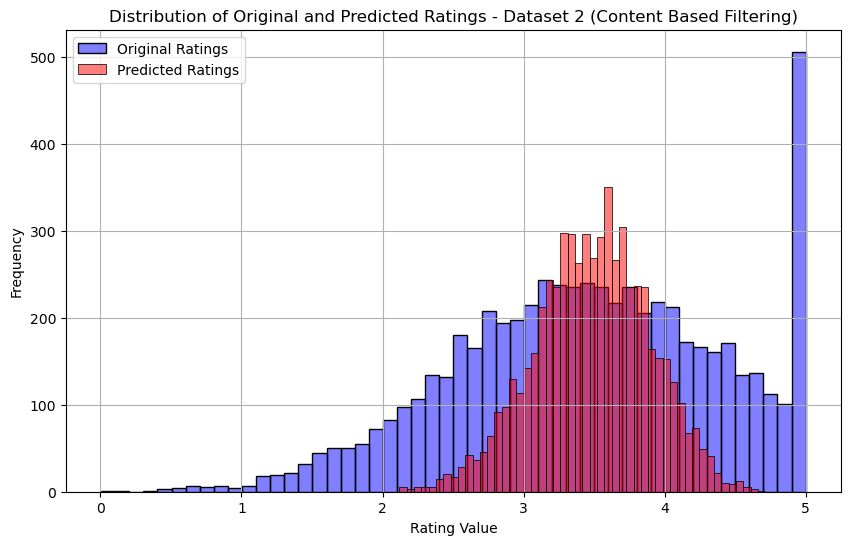

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, color='blue', alpha=0.5, label='Original Ratings')
sns.histplot(y_knn_pred, bins=50, color='red', alpha=0.5, label='Predicted Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Predicted Ratings - Dataset 2 (Content Based Filtering)')
plt.legend()
plt.grid(True)
plt.show()